# **Разработка системы семантического поиска в базе знаний для системы поддержки**

**Постановка задачи**

Исследовать различные методы поиска необходимой инструкции в базе знаний по вопросу пользователя.

# Этапы работы
1. Создание датасета на основе данных вопрос->инструкция.
2. Получение векторных представлений вопросов и инструкций с помощью BERT и TF-IDF.
3. С помощью векторных представлений анализ расстояний между вопросами и инструкциями.
3. Классификация вопросов пользователей на полученных эмбеддингах.
4. Анализ метрик ранжирования и классификации по всем экспериментам для выявления наилучшего метода поиска подходящей инструкции по вопросу пользователя.

Метрики:
- в качестве меры близости векторов используем косинусное расстояние и манхеттенское расстояние;
- в качестве метрики ранжирования используем map@K
- в качестве основной метрики классификации используем RocAuc

**Данные**

Инструкции по решению частых проблем пользователей: https://docs.amvera.ru/general/faq.html. Список вопросов пользователей сформировать на основе анализа канала поддержки: https://t.me/amverachat.

In [102]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [103]:
import warnings
warnings.filterwarnings("ignore")

Словарь для хранения метрик по исследованным методам.

In [104]:
methods_metrics = dict()

# Получение данных

In [105]:
url = 'https://docs.amvera.ru/'
general_page = 'general/'
faq_page = 'faq.html'

In [106]:
page = requests.get(url + general_page + faq_page)

In [107]:
print(page.status_code)

200


In [108]:
soup = BeautifulSoup(page.text, "html.parser", from_encoding='utf-8')

In [109]:
links = [a.get('href') for a in soup.select("div[class^='toctree-wrapper compound'] > ul > li > a")]

In [110]:
links

['FAQ/errors-in-logs.html',
 'FAQ/update.html',
 'FAQ/data-saving.html',
 'FAQ/502-503-error.html',
 'FAQ/infinite-build-run.html',
 'FAQ/tgbot.html',
 'FAQ/enverror.html',
 'FAQ/not-found-file.html',
 'FAQ/UTC-time.html',
 '../applications/git/freq-errors.html',
 'FAQ/payments.html']

In [111]:
instr_data = pd.DataFrame()
instr_data['link'] = pd.Series(links).apply(lambda item: list(re.split('[/.]', item))[-2])

In [112]:
articles = []
for l in links:
    if l[:3] == '../':
        part_of_link = ''
    else:
        part_of_link = general_page
    full_link = url+part_of_link+l.lstrip('../')
    #print(full_link)
    page = requests.get(full_link)
    page.encoding = 'cp1251'
    if page.status_code == 200:
        soup = BeautifulSoup(page.text, "html.parser")
        articles.append(soup.article.get_text().encode('cp1251', 'ignore').decode('utf-8', 'ignore').replace('¶', ''))

In [113]:
instr_data['row_article'] = pd.Series(np.array(articles))

In [114]:
pd.set_option('display.max_colwidth', 2000)

DataFrame instr_data содержит название инструкции и ее текстовое содержание

In [115]:
instr_data

,link,row_article
0,errors-in-logs,"\n\nОшибки в логах и их причины\nНа данной странице собраны самые основные и популярные ошибки, возникающие при деплое приложения различных окружений.\n\nОшибки, актуальные для всех окружений\nСамая распространенная ошибка связана с некорректным указанием пути к базе данных SQLite. Подробно о работе с SQLite здесь: SQLite\n\nRUNNING - FAILED - SUCCEEDED - DELETED в цикле лога приложения (не сборки)\nЕсли статусы в логе приложения (не лог сборки) ушли в подобный бесконечный цикл.\n\nПовысьте тариф до одного из старших. Скорее всего приложению не хватает ресурса, чтобы запуститься. Потом его можно будет понизить.\nПроверьте, что вы загрузили не пустые файлы. Для этого скачайте код из раздела «Репозиторий» и посмотрите содержимое.\n\nВажно, статус DELETED не является ошибкой работы проекта. Это нормальный статус при сборке и запуске приложения.\n\n\nTerminated by other getupdates request (Телеграм бот)\nЭкземляр бота конфликтует с другим\nНужно:\n\nУбедиться, что выставлен только 1 инстанс. Телеграм боты в режиме опроса не поддерживают горизонтальное масштабирование\nУбедиться, что токен бота больше нигде не используется и бот нигде не запущен.\n\nПроще всего просто сбросить токен в @BotFather\n\n\nPermission denied - не все файлы после заморозки/пересборки проекта удалились/обновились:\nЕсли заморозить проект и сразу же пересобрать, то папка venv в Artifacts, отвечающая за окружение Python, повреждается,\nне успевая удалиться перед новой сборкой, из-за чего возникают ошибки вида:\n\nERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/.local'\n/app/venv/bin/python3: No module named pip.__main__; 'pip' is a package and cannot be directly executed\nError: [Errno 13] Permission denied: '/app/venv'\n\nРешить можно полной очисткой Artifacts. Для этого нужно перейти в «Настройки» и повторно заморозить проект, но на этот раз дать больше времени (около 3 минут) для того, чтобы папка venv успевала удалиться и не вызывала конфликтов во время..."
1,update,"\n\nНе получается обновить проект\nВозможные причины:\n\nНеверная последовательность команд git\nЧастой ошибкой является неверная последовательность команд git (когда проект уже запущен и нужно его обновить)\nСимптомом является ответ команды git, когда вы изменяли код и выполнили git push:\nEverything up-to-date\n\n\nВам поможет следующая последовательность команд:\ngit add .\ngit commit -m ""Описание сделанных изменений""\ngit push amvera master\n\n\nНе забудьте про точку в первой команде - она нужна. При этом убедитесь, что файлы, содержащие конфиденциальную информацию (по типу токенов), такие как .env, находятся в .gitignore. Переменные окружения лучше всего указывать именно во вкладке «Переменные» проекта.\n\n\nСборка/развертывание перестала работать\nПроект ранее успешно обновлялся, но в этот раз сборка/развертывание не работает.\nРекомендуем заморозить приложение через интерфейс личного кабинета во вкладке «Настройки», подождать пару минут и повторить\npush/сборку. В ряде случаев данная ошибка может быть вызвана старыми артефактами и их удаление может помочь.\nЕсли ни один из способов выше не помогает, вы можете пересоздать проект с новым именем.\n\nВнимание\nЗаморзка проекта остановит все текущие инстансы приложения без возможности их запуска без пересборки.\n\n\nПодсказка\nЕсли не получается разобраться, пишите в поддержку support@amvera.ru. Просим сразу указывать имя пользователя и проекта. Мы постараемся помочь.\n\n\n\n"
2,data-saving,"\n\nНе сохраняются данные при перезапуске/пересборке приложения/базы данных\nЕсли при перезапуске/пересборке проекта ваши данные не сохраняются, убедитесь, что вы их сохраняете в каталог /data.\nДанная директория специально создана нами для того, чтобы при перезапусках проектов, пересборке и т.д. все ваши данные\nбыли сохранны и доступны.\nПомимо этого, данные хранимые в /data мы сохраняем в трёх экземплярах на разных узлах кластера, дополнительно делая\nрегулярные бэкапы, что сн

DataFrame ques_instr_data содержит список вопросов и название инструкций, в которой содержится ответ на заданный вопрос. А так же создадим столбец instruction_num - содержит индекс инструкции из instr_data, необходимый для multiclass классификации.

In [116]:
ques_instr_data = pd.read_csv("ques_instr.csv",sep=';', names = ['instruction', 'question'])
ques_instr_data['instruction_num'] = ques_instr_data['instruction'].apply(lambda row: instr_data[instr_data['link'] == row].index.values.tolist()[0])
ques_instr_data

,instruction,question,instruction_num
0,update,"писать git commit, но бот не останавливался",1
1,update,коммить уже задеплоенного бота,1
2,update,проекты не получают обновление с гита,1
3,update,"переодически приложение зависает в статусе сборки, хотя сервис досупен публично",1
4,update,проблема обновления проекта (бот в телеге),1
...,...,...,...
158,data-saving,сохраняете в /data базу данных SQLite,2
159,data-saving,при перезапуске/пересборке проекта данные не сохраняются,2
160,UTC-time,UTC,8
161,UTC-time,на серверах Amvera время - UTC,8


# Визуализация данных

Из гистограммы ниже видно неравномерное распределение количества вопросов по инструкциям

<BarContainer object of 11 artists>

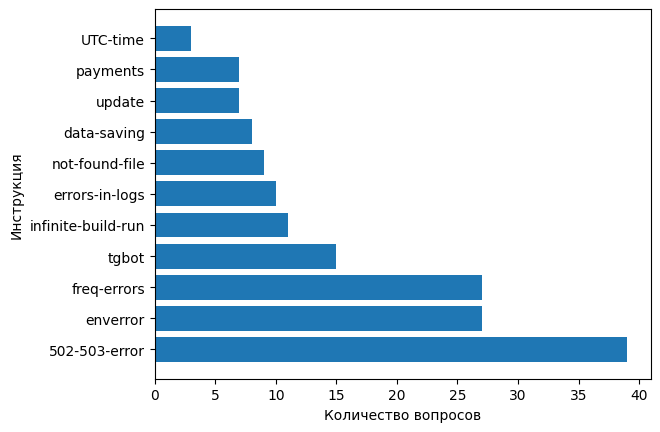

In [117]:
instructions = ques_instr_data['instruction'].value_counts()
plt.xlabel('Количество вопросов')
plt.ylabel('Инструкция')
plt.barh(y=instructions.index, width=instructions.values)

В данных присутствует явный дисбаланс представленных классов, поэтому в качестве метрики на задачах классификации выберем RocAuc.

# Предподготовка данных

In [118]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [119]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [120]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))
#lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
stop_words_ru = set(stopwords.words('russian'))
stop_words = stop_words_en.union(stop_words_ru).union(('(', ')', '«', '»', '-', '#', '@', ',', ', ', '.', ':','error', 'ошибка', 'ошибку', 'ошибки', 'ошибкой', 'помощь', 'помогать'))

In [122]:
#функция удаляет стоп-слова и приводит к нижнему регистру text
def preprocess(text):
    text = list(word_tokenize(text.lower()))
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [123]:
instr_data['article_join'] = instr_data['row_article'].apply(preprocess)
instr_data

,link,row_article,article_join
0,errors-in-logs,"\n\nОшибки в логах и их причины\nНа данной странице собраны самые основные и популярные ошибки, возникающие при деплое приложения различных окружений.\n\nОшибки, актуальные для всех окружений\nСамая распространенная ошибка связана с некорректным указанием пути к базе данных SQLite. Подробно о работе с SQLite здесь: SQLite\n\nRUNNING - FAILED - SUCCEEDED - DELETED в цикле лога приложения (не сборки)\nЕсли статусы в логе приложения (не лог сборки) ушли в подобный бесконечный цикл.\n\nПовысьте тариф до одного из старших. Скорее всего приложению не хватает ресурса, чтобы запуститься. Потом его можно будет понизить.\nПроверьте, что вы загрузили не пустые файлы. Для этого скачайте код из раздела «Репозиторий» и посмотрите содержимое.\n\nВажно, статус DELETED не является ошибкой работы проекта. Это нормальный статус при сборке и запуске приложения.\n\n\nTerminated by other getupdates request (Телеграм бот)\nЭкземляр бота конфликтует с другим\nНужно:\n\nУбедиться, что выставлен только 1 инстанс. Телеграм боты в режиме опроса не поддерживают горизонтальное масштабирование\nУбедиться, что токен бота больше нигде не используется и бот нигде не запущен.\n\nПроще всего просто сбросить токен в @BotFather\n\n\nPermission denied - не все файлы после заморозки/пересборки проекта удалились/обновились:\nЕсли заморозить проект и сразу же пересобрать, то папка venv в Artifacts, отвечающая за окружение Python, повреждается,\nне успевая удалиться перед новой сборкой, из-за чего возникают ошибки вида:\n\nERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/.local'\n/app/venv/bin/python3: No module named pip.__main__; 'pip' is a package and cannot be directly executed\nError: [Errno 13] Permission denied: '/app/venv'\n\nРешить можно полной очисткой Artifacts. Для этого нужно перейти в «Настройки» и повторно заморозить проект, но на этот раз дать больше времени (около 3 минут) для того, чтобы папка venv успевала удалиться и не вызывала конфликтов во время...",логах причины данной странице собраны самые основные популярные возникающие деплое приложения различных окружений актуальные окружений самая распространенная связана некорректным указанием пути базе данных sqlite подробно работе sqlite sqlite running failed succeeded deleted цикле лога приложения сборки статусы логе приложения лог сборки ушли подобный бесконечный цикл повысьте тариф одного старших скорее приложению хватает ресурса запуститься понизить проверьте загрузили пустые файлы скачайте код раздела репозиторий посмотрите содержимое важно статус deleted является работы проекта это нормальный статус сборке запуске приложения terminated getupdates request телеграм бот экземляр бота конфликтует другим нужно убедиться выставлен 1 инстанс телеграм боты режиме опроса поддерживают горизонтальное масштабирование убедиться токен бота нигде используется бот нигде запущен проще просто сбросить токен botfather permission denied файлы заморозки/пересборки проекта удалились/обновились заморозить проект сразу пересобрать папка venv artifacts отвечающая окружение python повреждается успевая удалиться новой сборкой из-за возникают вида could install packages due oserror [ errno 13 ] permission denied '/.local ' /app/venv/bin/python3 module named pip.__main__ ; 'pip ' package directly executed [ errno 13 ] permission denied '/app/venv ' решить полной очисткой artifacts нужно перейти настройки повторно заморозить проект дать времени около 3 минут папка venv успевала удалиться вызывала конфликтов время сборки заморозка помогла ранее проект успешно собирался попробуйте развернуть приложение новом проекте напишите support amvera.ru python некоторые коды ошибок следствия могут относиться различным окружениям modulenotfounderror importerror modulenotfounderror module named ' ... ' importerror import name ' ... ' ' ... ' /app/ ... говорит импортируемая библиотека модуль пакет найден случае импортируется стороннаяя библиотека pip сверить 

In [124]:
ques_instr_data['question_join'] = ques_instr_data['question'].apply(preprocess)
ques_instr_data

,instruction,question,instruction_num,question_join
0,update,"писать git commit, но бот не останавливался",1,писать git commit бот останавливался
1,update,коммить уже задеплоенного бота,1,коммить задеплоенного бота
2,update,проекты не получают обновление с гита,1,проекты получают обновление гита
3,update,"переодически приложение зависает в статусе сборки, хотя сервис досупен публично",1,переодически приложение зависает статусе сборки хотя сервис досупен публично
4,update,проблема обновления проекта (бот в телеге),1,проблема обновления проекта бот телеге
...,...,...,...,...
158,data-saving,сохраняете в /data базу данных SQLite,2,сохраняете /data базу данных sqlite
159,data-saving,при перезапуске/пересборке проекта данные не сохраняются,2,перезапуске/пересборке проекта данные сохраняются
160,UTC-time,UTC,8,utc
161,UTC-time,на серверах Amvera время - UTC,8,серверах amvera время utc


In [125]:
# количество наиболее подходящих инструкций к вопросу, полученных исследуемыми методами
K = 2

In [126]:
#функция подсчета адаптированной метрики качества ранжирования
def eval_mapK(row, col):
    indx = K
    for i in range(0, K):
        if row['instruction'] == row[col][i]:
            indx = i
            break
    return (K-indx)/K

# Векторные представления текстов инструкций и вопросов с TfIdf

In [127]:
Tfidf_vectorizer = TfidfVectorizer()

In [128]:
tf_idf_instr = Tfidf_vectorizer.fit_transform(instr_data['article_join'])

In [129]:
tf_idf_instr.shape

(11, 1182)

In [130]:
tf_idf_ques = Tfidf_vectorizer.transform(ques_instr_data['question_join'])

In [131]:
tf_idf_ques.shape

(163, 1182)

Манхеттенское расстояние между векторами TfIdf вопросов и инструкций

In [132]:
manhattan_dist = pairwise_distances(tf_idf_ques, tf_idf_instr, metric='manhattan' )

Косинусное расстояние между векторами TfIdf вопросов и инструкций

In [133]:
cosine_dist = pairwise_distances(tf_idf_ques, tf_idf_instr, metric='cosine' )

In [134]:
mapK_cols = [] #список c названиями столбцов, содержащих оценки метрики качества ранжирования исследованных методов
pred_Kcols = [] #список с названиями столбцов, содержащих предсказанные К рекомендованных инструкций

# функция создает 2 столбца в DataFrame df: 1. "K" рекоммендованных инструкций; 2. оценку метрики качества
def create_pred_mapK_cols(df, pred_model, index, col_postfix, K, inverse = False):
  if inverse:
    tmp_list = [list(np.argsort(pred_model[i]))[::-1][:K] for i in range(pred_model.shape[0])]
  else:
    tmp_list = [list(np.argsort(pred_model[i]))[:K] for i in range(pred_model.shape[0])]
  df['pred_'+ col_postfix] = pd.Series(tmp_list, index = index) \
   .apply(lambda indx: list(instr_data.iloc[indx,0]))
  df['map@K_' + col_postfix] = df.apply(eval_mapK, axis=1, args = ('pred_' + col_postfix,))
  mapK_cols.append('map@K_' + col_postfix)
  pred_Kcols.append('pred_'+ col_postfix)

Столбец ques_instr_data.pred_tfidf_manhattan - "K" ближайших к вопросу инструкций, полученных оценкой манхеттенского расстояния на векторах TfIdf; ques_instr_data.map@K_tfidf_manhattan - оценка качества рекоммендации

In [135]:
create_pred_mapK_cols(ques_instr_data, manhattan_dist, ques_instr_data.index, 'tfidf_manhattan', K)

Столбец ques_instr_data.pred_tfidf_cosine - "K" ближайших к вопросу инструкций, полученных оценкой косинусного расстояния на векторах TfIdf; ques_instr_data.map@K_tfidf_cosine - оценка качества рекоммендации

In [136]:
create_pred_mapK_cols(ques_instr_data, cosine_dist, ques_instr_data.index, 'tfidf_cosine', K)

In [137]:
ques_instr_data

,instruction,question,instruction_num,question_join,pred_tfidf_manhattan,map@K_tfidf_manhattan,pred_tfidf_cosine,map@K_tfidf_cosine
0,update,"писать git commit, но бот не останавливался",1,писать git commit бот останавливался,"[UTC-time, payments]",0.0,"[freq-errors, update]",0.5
1,update,коммить уже задеплоенного бота,1,коммить задеплоенного бота,"[UTC-time, payments]",0.0,"[tgbot, errors-in-logs]",0.0
2,update,проекты не получают обновление с гита,1,проекты получают обновление гита,"[UTC-time, payments]",0.0,"[infinite-build-run, freq-errors]",0.0
3,update,"переодически приложение зависает в статусе сборки, хотя сервис досупен публично",1,переодически приложение зависает статусе сборки хотя сервис досупен публично,"[UTC-time, payments]",0.0,"[502-503-error, infinite-build-run]",0.0
4,update,проблема обновления проекта (бот в телеге),1,проблема обновления проекта бот телеге,"[UTC-time, payments]",0.0,"[tgbot, payments]",0.0
...,...,...,...,...,...,...,...,...
158,data-saving,сохраняете в /data базу данных SQLite,2,сохраняете /data базу данных sqlite,"[UTC-time, data-saving]",0.5,"[data-saving, errors-in-logs]",1.0
159,data-saving,при перезапуске/пересборке проекта данные не сохраняются,2,перезапуске/пересборке проекта данные сохраняются,"[UTC-time, data-saving]",0.5,"[data-saving, freq-errors]",1.0
160,UTC-time,UTC,8,utc,"[UTC-time, payments]",1.0,"[UTC-time, errors-in-logs]",1.0
161,UTC-time,на серверах Amvera время - UTC,8,серверах amvera время utc,"[UTC-time, payments]",1.0,"[UTC-time, 502-503-error]",1.0


Средняя оценка качества рекоммендаций инструкций, полученных оценкой манхеттенского расстояния на векторах TfIdf

In [138]:
ques_instr_data['map@K_tfidf_manhattan'].mean()

np.float64(0.05521472392638037)

Средняя оценка качества рекоммендаций инструкций, полученных оценкой косинусного расстояния на векторах TfIdf

In [139]:
ques_instr_data['map@K_tfidf_cosine'].mean()

np.float64(0.647239263803681)

Из приведенных выше оценок Map@K видно, что качество рекомендаций при применении TfIdf векторов значительно лучше при использование косинусного расстояния.

Подсчитаем метрики классификации RocAuc и LogLoss на полученных оценках манхеттонских расстояний на тестовом множестве.

In [140]:
_, data_test = train_test_split(ques_instr_data['instruction_num'], test_size=0.15, random_state=123)

def prob_func(dist, count_el):
  probs = []
  for row in dist:
      temp_row = [0] * count_el
      temp_row[np.argmin(row)] = 1
      probs.append(temp_row)
  return probs

In [141]:
data_test_sm = prob_func(manhattan_dist[data_test.index], len(links))

Кросс-энтропия на test

In [142]:
output = log_loss(data_test, y_pred = data_test_sm, labels = range(0,11))
output

36.04365338911715

RocAuc метрика на test

In [143]:
roc_auc = roc_auc_score(data_test, data_test_sm, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

np.float64(0.5)

In [144]:
methods_metrics['manhattan dist TfIdf'] = [roc_auc, output]

Подсчитаем метрики классификации RocAuc и LogLoss на полученных оценках косинусных расстояний на тестовом множестве.

In [145]:
data_test_sm = prob_func(cosine_dist[data_test.index], len(links))

Кросс-энтропия на test

In [146]:
output = log_loss(data_test, y_pred = data_test_sm, labels = range(0,11))
output

11.533969084517489

RocAuc метрика на test

In [147]:
roc_auc = roc_auc_score(data_test, data_test_sm, labels = range(0,11), multi_class='ovo',average = 'weighted')
roc_auc

np.float64(0.773690476190476)

In [148]:
methods_metrics['cosine dist TfIdf'] = [roc_auc, output]

# Векторные представления текстов инструкций и вопросов с Bert

Нейронная сеть Bert принимает на вход последовательности длиной не больше 512 токенов. Проверим длины текстов инструкций.

In [149]:
instr_data['article_join'].apply(len)

,article_join
0,5207
1,1164
2,1118
3,3086
4,3272
5,1830
6,1512
7,1716
8,337
9,3533


In [150]:
max_len = 0

In [151]:
#функция разбивает текст на части, содержащие не более 512 токенов
def get_chunks(row):
    global max_len
    local = row.strip('\n\n').split('\n\n')
    local = [local[i] for i in range(len(local)) if i not in [i for i in range(len(local)) if len(local[i]) == 0]]
    for i,chunk in enumerate(local):
        if len(chunk) > 512:
            num_subchunks = len(chunk)//512 + 1
            start_pos = len(chunk)//num_subchunks
            sep_pos = chunk[:start_pos].rfind('\n')
            if sep_pos == -1:
                sep_pos = chunk[:start_pos].rfind('.')
                if sep_pos == -1:
                    sep_pos = chunk[:start_pos].rfind(' ')
            local.append(chunk[(sep_pos+1):])
            local[i] = chunk[:(sep_pos)]
        local[i] = preprocess(local[i])
        if max_len < len(local[i]):
          max_len = len(local[i])
    return local

In [152]:
instr_data['article_chunks'] = instr_data['row_article'].apply(get_chunks)

In [153]:
# функция max пуллинга на векторами
def max_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    max_embeddings = torch.max(token_embeddings * input_mask_expanded, 1).values
    return max_embeddings

In [154]:
# функция mean пуллинга на векторами
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

Скачиваем токенизатор и предобученную модель BERT (для руссского языка)

In [155]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

# функция возвращает эмбеддинги sentences, полученные с помощью BERT
def get_bert_vectors(sentences, func):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = func(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

In [156]:
pool_func = mean_pooling

Вектора BERT для инструкций, используя mean pooling

In [157]:
instr_mean_bert_vectors = instr_data['article_chunks'].apply(get_bert_vectors, args = (pool_func,))

Вектора BERT для вопросов, используя mean pooling

In [158]:
ques_mean_bert_vectors = ques_instr_data['question_join'].apply(get_bert_vectors, args = (pool_func,))

In [ ]:
# функция возвращает "K" инструкций, соответствующих минимальным упорядоченным расстояниям между эмбеддингом текущего вопроса и эмбеддингами инструкций
def get_dist(row, instr_bert_vectors, dist):
  bert_dist = []
  for i in range(len(instr_bert_vectors)):
    bert_dist.append(np.min(pairwise_distances(row, instr_bert_vectors[i].numpy(), metric=dist)[0]))
  return list(np.argsort(bert_dist))[:K]

In [160]:
# функция возвращает расстояния между эмбеддингом текущего вопроса и эмбеддингами инструкций
def get_all_dist(row, instr_bert_vectors, dist):
  bert_dist = []
  for i in range(len(instr_bert_vectors)):
    bert_dist.append(np.min(pairwise_distances(row, instr_bert_vectors[i].numpy(), metric=dist)[0]))
  return bert_dist

Столбец ques_instr_data.pred_mean_bert_manhattan - "K" ближайших к вопросу инструкций, полученных оценкой манхеттенского расстояния на векторах BERT с mean pooling; ques_instr_data.map@K_mean_bert_manhattan - оценка качества рекоммендации

In [161]:
ques_instr_data['pred_mean_bert_manhattan'] = ques_mean_bert_vectors.apply(get_dist, args = (instr_mean_bert_vectors, 'manhattan',)).apply(lambda indx: list(instr_data.iloc[indx,0]))
ques_instr_data['map@K_mean_bert_manhattan'] = ques_instr_data.apply(eval_mapK, axis=1, args = ('pred_mean_bert_manhattan',))
mapK_cols.append('map@K_mean_bert_manhattan')

Столбец ques_instr_data.pred_mean_bert_cosine - "K" ближайших к вопросу инструкций, полученных оценкой косинусного расстояния на векторах BERT с mean pooling; ques_instr_data.map@K_mean_bert_cosine - оценка качества рекоммендации

In [162]:
ques_instr_data['pred_mean_bert_cosine'] = ques_mean_bert_vectors.apply(get_dist, args = (instr_mean_bert_vectors, 'cosine',)).apply(lambda indx: list(instr_data.iloc[indx,0]))
ques_instr_data['map@K_mean_bert_cosine'] = ques_instr_data.apply(eval_mapK, axis=1, args = ('pred_mean_bert_cosine',))
mapK_cols.append('map@K_mean_bert_cosine')

Средняя оценка качества рекоммендаций инструкций, полученных оценкой манхеттенского расстояния на векторах Bert с mean pooling

In [163]:
ques_instr_data['map@K_mean_bert_manhattan'].mean()

np.float64(0.3067484662576687)

Средняя оценка качества рекоммендаций инструкций, полученных оценкой косинусного расстояния на векторах Bert с mean pooling

In [164]:
ques_instr_data['map@K_mean_bert_cosine'].mean()

np.float64(0.32515337423312884)

Из приведенных выше оценок видно, что качество рекомендаций при применении Bert c mean pooling векторов немного лучше при использование косинусного расстояния нежели манхеттенского. Однако оценка косинусных расстояний на эмбеддингах Bert в два раза уступает аналогичной оценки на TfIdf.

Подсчитаем метрики классификации RocAuc и LogLoss на полученных оценках манхеттонских расстояний на тестовом множестве.

In [165]:
manhattan_dist = ques_mean_bert_vectors.apply(get_all_dist, args = (instr_mean_bert_vectors, 'manhattan',))
data_test_sm = prob_func(manhattan_dist[data_test.index], len(links))

Кросс-энтропия на test

In [166]:
output = log_loss(data_test, y_pred = data_test_sm, labels = range(0,11))
output

25.951430440164348

RocAuc метрика на test

In [167]:
roc_auc = roc_auc_score(data_test, data_test_sm, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

np.float64(0.5677083333333333)

In [168]:
methods_metrics['manhattan dist Bert mean'] = [roc_auc, output]

Подсчитаем метрики классификации RocAuc и LogLoss на полученных оценках косинусных расстояний на тестовом множестве.

In [169]:
cosine_dist = ques_mean_bert_vectors.apply(get_all_dist, args = (instr_mean_bert_vectors, 'cosine',))
data_test_sm = prob_func(cosine_dist[data_test.index], len(links))

Кросс-энтропия на test

In [170]:
output = log_loss(data_test, y_pred = data_test_sm, labels = range(0,11))
output

25.951430440164348

RocAuc метрика на test

In [171]:
roc_auc = roc_auc_score(data_test, data_test_sm, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

np.float64(0.5677083333333334)

In [172]:
methods_metrics['cosine dist Bert mean'] = [roc_auc, output]

In [173]:
pool_func = max_pooling

Вектора BERT для инструкций, используя max pooling

In [174]:
instr_max_bert_vectors = instr_data['article_chunks'].apply(get_bert_vectors, args = (pool_func,))

Вектора BERT для вопросов, используя max pooling

In [ ]:
ques_max_bert_vectors = ques_instr_data['question_join'].apply(get_bert_vectors, args = (pool_func,))

Столбец ques_instr_data.pred_max_bert_manhattan - "K" ближайших к вопросу инструкций, полученных оценкой манхеттенского расстояния на векторах BERT с max pooling; ques_instr_data.map@K_max_bert_manhattan - оценка качества рекоммендации

In [ ]:
ques_instr_data['pred_max_bert_manhattan'] = ques_max_bert_vectors.apply(get_dist, args = (instr_max_bert_vectors, 'manhattan',)).apply(lambda indx: list(instr_data.iloc[indx,0]))
ques_instr_data['map@K_max_bert_manhattan'] = ques_instr_data.apply(eval_mapK, axis=1, args = ('pred_max_bert_manhattan',))
mapK_cols.append('map@K_max_bert_manhattan')

Столбец ques_instr_data.pred_max_bert_cosine - "K" ближайших к вопросу инструкций, полученных оценкой косинусного расстояния на векторах BERT с max pooling; ques_instr_data.map@K_max_bert_cosine - оценка качества рекоммендации

In [ ]:
ques_instr_data['pred_max_bert_cosine'] = ques_max_bert_vectors.apply(get_dist, args = (instr_max_bert_vectors, 'cosine',)).apply(lambda indx: list(instr_data.iloc[indx,0]))
ques_instr_data['map@K_max_bert_cosine'] = ques_instr_data.apply(eval_mapK, axis=1, args = ('pred_max_bert_cosine',))
mapK_cols.append('map@K_max_bert_cosine')

Средняя оценка качества рекоммендаций инструкций, полученных оценкой манхеттенского расстояния на векторах Bert с max pooling

In [ ]:
ques_instr_data['map@K_max_bert_manhattan'].mean()

Средняя оценка качества рекоммендаций инструкций, полученных оценкой косинусного расстояния на векторах Bert с max pooling

In [ ]:
ques_instr_data['map@K_max_bert_cosine'].mean()

Из приведенных выше оценок видно, что качество рекомендаций при применении Bert c max pooling векторов совсем немного лучше при использование косинусного расстояния нежели манхеттенского. Однако оценка косинусных расстояний на эмбеддингах Bert немногим больше чем в два раза уступает аналогичной оценки на TfIdf.

Подсчитаем метрики классификации RocAuc и LogLoss на полученных оценках манхеттонских расстояний на тестовом множестве.

In [ ]:
manhattan_dist = ques_mean_bert_vectors.apply(get_all_dist, args = (instr_max_bert_vectors, 'manhattan',))
data_test_sm = prob_func(manhattan_dist[data_test.index], len(links))

Кросс-энтропия на test

In [ ]:
output = log_loss(data_test, y_pred = data_test_sm, labels = range(0,11))
output

RocAuc метрика на test

In [ ]:
roc_auc = roc_auc_score(data_test, data_test_sm, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

In [ ]:
methods_metrics['manhattan dist Bert mean'] = [roc_auc, output]

Подсчитаем метрики классификации RocAuc и LogLoss на полученных оценках косинусных расстояний на тестовом множестве.

In [ ]:
cosine_dist = ques_mean_bert_vectors.apply(get_all_dist, args = (instr_max_bert_vectors, 'cosine',))
data_test_sm = prob_func(cosine_dist[data_test.index], len(links))

Кросс-энтропия на test

In [ ]:
output = log_loss(data_test, y_pred = data_test_sm, labels = range(0,11))
output

RocAuc метрика на test

In [ ]:
roc_auc = roc_auc_score(data_test, data_test_sm, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

In [ ]:
methods_metrics['cosine dist Bert max'] = [roc_auc, output]

# XGBoost для классификации векторов TfIdf вопросов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_ques, ques_instr_data['instruction_num'], test_size=0.15, random_state = 123)

Так как обучающий набор данных мал, необходимо проследить, чтобы в train наборе были представлены все классы таргета.

In [ ]:
y_train.value_counts()

In [ ]:
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=200,
                          objective= 'multi:softprob',
                          nthread=-1,
                          seed=27)

Подберем гиперпараметры с помощью GridSearchCV.

In [191]:
from sklearn.model_selection import GridSearchCV

param_test = {
    'max_depth':range(2,7,2),
    'min_child_weight':range(1,6,2)
}

gsearch = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test,
                        scoring='roc_auc_ovo',
                        n_jobs=-1,
                        cv=3)

gsearch.fit(X_train,y_train)

gsearch.best_params_, gsearch.best_score_

({'max_depth': 4, 'min_child_weight': 1}, np.float64(0.6801499331596735))

Используем полученные параметры.

In [ ]:
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=200,
                          objective= 'multi:softprob',
                          max_depth = 4,
                          min_child_weight = 1,
                          nthread=-1,
                          seed=27)

In [ ]:
model_xgb.fit(X_train,y_train)
y_pred_train_XGB_tfidf = model_xgb.predict_proba(X_train)
y_pred_test_XGB_tfidf = model_xgb.predict_proba(X_test)

Кросс-энтропия на train

In [ ]:
output = log_loss(y_train, y_pred = y_pred_train_XGB_tfidf, labels = range(0,11))
output

Кросс-энтропия на test

In [195]:
output = log_loss(y_test, y_pred = y_pred_test_XGB_tfidf, labels = range(0,11))
output

1.727452229529076

RocAuc метрика на train

In [ ]:
roc_auc_score(y_train, y_pred_train_XGB_tfidf, multi_class='ovo',average = 'macro')

RocAuc метрика на test

In [197]:
roc_auc = roc_auc_score(y_test, y_pred_test_XGB_tfidf, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

np.float64(0.6816716269841269)

In [198]:
methods_metrics['XGB TfIdf'] = [roc_auc, output]

# XGBoost для классификации векторов Bert вопросов

In [199]:
def convert_to_list(row):
  return row.squeeze().tolist()

In [200]:
ques_mean_bert_vectors = ques_mean_bert_vectors.apply(convert_to_list)

In [201]:
ques_mean_bert_vectors_list = ques_mean_bert_vectors.tolist()

Разбиение  на test и train аналогичное, что и для векторов TfIdf из предыдущего эксперимента

In [202]:
X_train, X_test, y_train, y_test = train_test_split(ques_mean_bert_vectors_list, ques_instr_data['instruction_num'], test_size=0.15, random_state = 123)

In [203]:
y_train.value_counts()

,count
instruction_num,
3,31
9,23
6,21
5,14
4,10
7,8
2,8
1,7
0,7


In [204]:
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=150,
                          objective= 'multi:softprob',
                          nthread=-1,
                          seed=27)

In [ ]:
gsearch = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test,
                        scoring='roc_auc_ovo',
                        n_jobs=-1,
                        cv=3)

gsearch.fit(X_train,y_train)

gsearch.best_params_, gsearch.best_score_

Используем полученные параметры.

In [ ]:
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=150,
                          objective= 'multi:softprob',
                          max_depth = 4,
                          min_child_weight = 5,
                          nthread=-1,
                          seed=27)

In [ ]:
model_xgb.fit(X_train,y_train)
y_pred_train_XGB_bert = model_xgb.predict_proba(X_train)
y_pred_test_XGB_bert = model_xgb.predict_proba(X_test)

Кросс-энтропия на train

In [ ]:
output = log_loss(y_train, y_pred = y_pred_train_XGB_bert, labels = range(0,11))
output

Кросс-энтропия на test

In [ ]:
output = log_loss(y_test, y_pred = y_pred_test_XGB_bert, labels = range(0,11))
output

RocAuc метрика на train

In [ ]:
roc_auc_score(y_train, y_pred_train_XGB_bert, multi_class='ovo',average = 'macro')

RocAuc метрика на test

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_test_XGB_bert, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

In [ ]:
methods_metrics['XGB Bert'] = [roc_auc, output]

Из приведенных выше оценок экспериментов с XGBoost видно, что качество классификации при использовании Bert mean pooling векторов меньше чем при использовании TfIdf векторов.

## Логистическая регрессия на TfIdf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_ques, ques_instr_data['instruction_num'], test_size=0.15, random_state = 123)

In [ ]:
LR_model = LogisticRegression(max_iter = 300, random_state=123).fit(X_train,y_train)
y_pred_train_LR_tfidf = LR_model.predict_proba(X_train)
y_pred_test_LR_tfidf = LR_model.predict_proba(X_test)

Кросс-энтропия на train

In [ ]:
output = log_loss(y_train, y_pred = y_pred_train_LR_tfidf, labels = range(0,11))
output

Кросс-энтропия на test

In [ ]:
output = log_loss(y_test, y_pred = y_pred_test_LR_tfidf, labels = range(0,11))
output

RocAuc метрика на train

In [ ]:
roc_auc_score(y_train, y_pred_train_LR_tfidf, multi_class='ovo',average = 'macro')

RocAuc метрика на test

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_test_LR_tfidf, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

In [ ]:
methods_metrics['Logistic Regression TfIdf'] = [roc_auc, output]

## Логистическая регрессия на Bert

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ques_mean_bert_vectors_list, ques_instr_data['instruction_num'], test_size=0.15, random_state = 123)

In [ ]:
LR_model = LogisticRegression(max_iter = 200).fit(X_train,y_train)
y_pred_train_LR_bert = LR_model.predict_proba(X_train)
y_pred_test_LR_bert = LR_model.predict_proba(X_test)

Кросс-энтропия на train

In [ ]:
output = log_loss(y_train, y_pred = y_pred_train_LR_bert, labels = range(0,11))
output

Кросс-энтропия на test

In [ ]:
output = log_loss(y_test, y_pred = y_pred_test_LR_bert, labels = range(0,11))
output

RocAuc метрика на train

In [ ]:
roc_auc_score(y_train, y_pred_train_LR_bert, multi_class='ovo',average = 'macro')

RocAuc метрика на test

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_test_LR_bert, labels = range(0,11), multi_class='ovo',average = 'macro')
roc_auc

In [ ]:
methods_metrics['Logistic Regression Bert'] = [roc_auc, output]

Из приведенных выше оценок экспериментов с Логистической регрессией видно, что качество классификации при использовании Bert mean pooling векторов фактически такое же, как и при использовании TfIdf векторов.

## Neural Network классификация

In [ ]:
# функция токенизирует вопросы с помощью Bert tokenizer
UNK_IX, PAD_IX = 100, 0

def as_matrix(sequences, max_len=None):
    if max_len is None:
        max_len = min(max(map(len, list(map(str.split, sequences)))), max_len or float('inf'))

    matrix = tokenizer(sequences.tolist(), padding=True, max_length= max_len, truncation=True, add_special_tokens = False, return_tensors='pt') #

    return matrix['input_ids']

Максимальная длина вопроса

In [ ]:
max_len = min(max(map(len, list(map(str.split, ques_instr_data['question_join'].values)))), max_len or float('inf'))
max_len

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#функция создает батчи с токенизированными вопросами
def make_batch(data, max_len=None, word_dropout=0, device=device):

    batch = {}
    batch["question"] = as_matrix(data['question_join'].values, max_len)
    batch["target"] = torch.tensor(data["instruction_num"].values, device=device)

    if word_dropout != 0:
        batch["question"] = apply_word_dropout(batch["question"], 1. - word_dropout)

    return batch

#функция делает drop out токенов с вероятностью keep_prop
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask = dropout_mask & matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
#класс классификатор вопросов с архитектурой NN
class QuestionPredictor(nn.Module):
    def __init__(self, n_tokens=tokenizer.vocab_size, hid_size=64, hid_size_l = 45):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, hid_size)
        self.ques_conv1 = nn.Conv1d(hid_size, hid_size, kernel_size=3, padding='same')
        self.relu_fun = nn.ReLU()
        self.batchNorm = nn.BatchNorm1d(hid_size)
        self.ques_conv2 = nn.Conv1d(hid_size, hid_size, kernel_size=3, padding='same')
        self.out_layers = nn.Sequential(
            nn.Linear(hid_size, hid_size_l),
            nn.ReLU(),
            nn.Linear(hid_size_l, len(links)),
            nn.Softmax(dim = 1)
        )

    def forward(self, batch):
        ques_emb = self.emb(batch["question"])

        ques_emb = ques_emb.transpose(1, 2)

        ques_conv = self.ques_conv1(ques_emb) # take: (batch_size, in_channels, seq_len)

        ques_pool = F.max_pool1d(self.batchNorm(self.relu_fun(ques_conv)), 4).squeeze(-1) #ques_conv.shape[2]

        ques_conv = self.ques_conv2(ques_pool)

        ques_pool = F.max_pool1d(self.relu_fun(ques_conv), ques_conv.shape[2]).squeeze(-1)

        out = self.out_layers(ques_pool)

        return out.squeeze(-1)

In [ ]:
model = QuestionPredictor().to(device)

In [ ]:
model

In [ ]:
data_train, data_val = train_test_split(ques_instr_data[['question_join','instruction_num']], test_size=0.15, random_state=123)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

In [ ]:
#функция итератор мини-батчей
def iterate_minibatches(data, batch_size=35, shuffle=True, cycle=False, device=device):

    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device)
            yield batch

        if not cycle: break

In [ ]:
BATCH_SIZE = 35
EPOCHS = 47

In [ ]:
# произведем вычисление весов классов для минимизации влияния неравномерности представленных классов в выборке - используется при подсчете кросс-энтропийного лосса
class_weights = compute_class_weight('balanced',classes = np.unique(ques_instr_data['instruction_num']),y = list(ques_instr_data['instruction_num']))
class_weights = torch.tensor(class_weights,dtype=torch.float, device=device)

In [ ]:
#функция подсчитывает и выводит на экран метрики качества f1-меру и RocAuc, а так же cross-entropy loss на валидации
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu')):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    ce_loss = roc_auc = num_samples = num_batches = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device):
            batch_pred = model(batch)
            ce_loss += criterion(batch_pred, batch['target'])
            roc_auc += roc_auc_score(batch['target'], batch_pred, labels = range(0,len(links)), multi_class='ovo')
            num_samples += len(batch_pred)
            num_batches += 1
    roc_auc = roc_auc / num_batches
    ce_loss = ce_loss / num_batches
    print("%s results:" % (name or ""))
    print("RocAuc: %.5f" % roc_auc)
    print("CrossEntropyLoss: %.5f" % ce_loss)
    return roc_auc, ce_loss

In [ ]:
#! pip install wandb

In [ ]:
#import wandb

In [ ]:
#wandb.init(project="question-class-model", name="QCM32")

Обучение NN-модели

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
global_step = 0

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        global_step += 1
        pred = model(batch)
        loss = criterion(pred, batch['target'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        roc_auc = roc_auc_score(batch['target'], pred.detach().cpu().numpy(), labels = range(0,len(links)), multi_class='ovo',average = 'weighted')
        wandb.log({"train/loss": loss.item(), "train/roc_auc": roc_auc}, step=global_step)

    roc_auc, ce_loss = print_metrics(model, data_val, device=device)
    wandb.log({"eval/loss": ce_loss, "eval/roc_auc": roc_auc}, step=global_step)
wandb.finish()

Предсказания NN для обучающего и тестового множеств

In [ ]:
with torch.no_grad():
    y_pred_test_nn = model(make_batch(data_val))

In [ ]:
methods_metrics['NN'] = [roc_auc, float(ce_loss)]

К сожалению, и с помощью NN не удалось повысить качество классификации. Попробуем проанализировать расстояние между векторными представлениями вопросов. Из теореческих размышлений можно прийти к выводу, что между вопросами одного кластера (точнее инструкции) расстояние должно быть меньше, чем между вопросами разных кластеров. Соответственно на heatmap должны быть отчетливо видны зоны малых расстояний, сгруппированные вокруг главной диагонали.

## Косинусное расстояние между вопросами на векторах TfIdf

In [ ]:
ques_tfidf_dist = pairwise_distances(tf_idf_ques, metric='cosine' )

In [ ]:
ax_lab = np.array(list(map(str, ques_instr_data['instruction_num'].copy().values)))

for i in range(len(links)):
  indices = np.where(ax_lab == str(i))[0]
  if len(indices) > 2:
    for j in range(indices[1],indices[-1]):
      ax_lab[j] = ''

plt.rcParams.update({'font.size': 7})
plt.figure(figsize=(15, 10))
sns.heatmap(ques_tfidf_dist, xticklabels=ax_lab, yticklabels=ax_lab)
plt.show()

Из тепловой карты видно, что расстояние между эмбеддингами вопросов TfIdf частично коррелирует с кластерами этих вопросов, соответственно использовать такой метод для классификации новых вопросов не целесообразно.

## Косинусное расстояние между вопросами на векторах Bert

In [ ]:
ques_bert_dist = pairwise_distances(ques_mean_bert_vectors_list, metric='cosine' )

In [ ]:
plt.rcParams.update({'font.size': 7})
plt.figure(figsize=(15, 10))
sns.heatmap(ques_bert_dist, xticklabels=ax_lab, yticklabels=ax_lab)
plt.show()

Из тепловой карты видно, что расстояние между эмбеддингами вопросов Bert не коррелирует с кластерами этих вопросов, соответственно использовать такой метод для классификации новых вопросов не целесообразно.

## Оценки метрики Map@K рекомендаций

В DataFrame ques_instr_data_val сохраним строки валидационного множества, которые использовались на тестовом прогоне при экспериментах на моделях XGBoost и NN.

In [ ]:
ques_instr_data_val = ques_instr_data.iloc[data_val.index].copy()

Следующий код добавляет столбцы в ques_instr_data_val с оценками метрики map@K для результатов экспериментов  с методами XGBoost, логистической регрессии и NN.

In [ ]:
create_pred_mapK_cols(ques_instr_data_val, y_pred_test_XGB_tfidf, data_val.index, 'XGB_tfidf', K, inverse = True)
create_pred_mapK_cols(ques_instr_data_val, y_pred_test_XGB_bert, data_val.index, 'XGB_bert', K, inverse = True)
create_pred_mapK_cols(ques_instr_data_val, y_pred_test_nn, data_val.index, 'nn', K, inverse = True)

In [ ]:
create_pred_mapK_cols(ques_instr_data_val, y_pred_test_LR_tfidf, data_val.index, 'LR_tfidf', K, inverse = True)
create_pred_mapK_cols(ques_instr_data_val, y_pred_test_LR_bert, data_val.index, 'LR_bert', K, inverse = True)

Приведем оценки метрики Map@K для каждого из рассмотреных методов на валидационном множестве.

In [ ]:
mean_mapK = ques_instr_data_val[mapK_cols].mean()
mean_mapK.rename('mean_mapK', inplace=True).sort_values(ascending=False, inplace=True)
mean_mapK

Из приведенной выше таблицы видно, что наилучший результат рекомендации инструкций к заданному вопросу удалось получить, оценивая косинусное расстояние между представлениями TfIdf вопросов и инструкций. Следующим по качеству идет классификация методом логистической регрессии на векторах TfIdf.

## Оценки метрики RocAuc классификации

In [ ]:
metrics = pd.DataFrame.from_dict(methods_metrics, orient='index', columns= ['RocAuc', 'LogLoss']).sort_values(ascending=False, by ='RocAuc')['RocAuc']
metrics.round(2)

Из приведенной выше таблицы видно, что наилучший результат классификации вопросов удалось получить, используя метод логистической регрессии на TfIdf векторах вопросов. Следующим по качеству идет оценка косинусного расстояния .

## "K" рекомендаций предсказанных каждым экспериментом

In [1028]:
ques_instr_data_val[['instruction'] + pred_Kcols]

,instruction,pred_tfidf_manhattan,pred_tfidf_cosine,pred_XGB_tfidf,pred_XGB_bert,pred_nn,pred_LR_tfidf,pred_LR_bert
140,502-503-error,"[UTC-time, payments]","[tgbot, errors-in-logs]","[tgbot, freq-errors]","[enverror, infinite-build-run]","[enverror, infinite-build-run]","[502-503-error, tgbot]","[enverror, infinite-build-run]"
91,enverror,"[UTC-time, payments]","[tgbot, errors-in-logs]","[502-503-error, enverror]","[enverror, infinite-build-run]","[freq-errors, enverror]","[freq-errors, enverror]","[freq-errors, enverror]"
86,enverror,"[UTC-time, payments]","[enverror, errors-in-logs]","[enverror, not-found-file]","[enverror, freq-errors]","[enverror, infinite-build-run]","[enverror, not-found-file]","[infinite-build-run, freq-errors]"
137,502-503-error,"[UTC-time, payments]","[502-503-error, errors-in-logs]","[502-503-error, enverror]","[502-503-error, enverror]","[502-503-error, enverror]","[502-503-error, freq-errors]","[errors-in-logs, freq-errors]"
33,freq-errors,"[UTC-time, payments]","[infinite-build-run, update]","[infinite-build-run, enverror]","[freq-errors, enverror]","[502-503-error, enverror]","[freq-errors, infinite-build-run]","[freq-errors, enverror]"
79,errors-in-logs,"[UTC-time, payments]","[errors-in-logs, tgbot]","[not-found-file, errors-in-logs]","[freq-errors, errors-in-logs]","[freq-errors, 502-503-error]","[not-found-file, 502-503-error]","[errors-in-logs, freq-errors]"
53,payments,"[UTC-time, payments]","[payments, errors-in-logs]","[freq-errors, 502-503-error]","[tgbot, payments]","[enverror, freq-errors]","[freq-errors, 502-503-error]","[errors-in-logs, payments]"
149,502-503-error,"[UTC-time, payments]","[502-503-error, freq-errors]","[freq-errors, 502-503-error]","[502-503-error, tgbot]","[enverror, freq-errors]","[freq-errors, 502-503-error]","[enverror, 502-503-error]"
65,infinite-build-run,"[UTC-time, payments]","[tgbot, infinite-build-run]","[tgbot, freq-errors]","[tgbot, enverror]","[errors-in-logs, enverror]","[tgbot, 502-503-error]","[tgbot, errors-in-logs]"
104,enverror,"[UTC-time, data-saving]","[data-saving, errors-in-logs]","[freq-errors, 502-503-error]","[freq-errors, 502-503-error]","[freq-errors, enverror]","[freq-errors, data-saving]","[data-saving, freq-errors]"
